# Linear Virtual Sensors

In this tutorial we will use linear approaches for virtual sensors to calculate the system response of an ESP System with external force from a shaker. The tutorial provides an introduction to virtual sensors for dynamic systems and focusses on applying linear approaches. More complex models are discussed in the other two tutorials on Autoregressive Neural Networks `ARNN.ipynb` and Recurrent Neural Networks `RNN.ipynb`.

## Loading Data
In a first step we load the already measured data and convert them into `pandas.DataFrames`. Our example Data consists of three individually Measured datasets. To load the data properly we need information about the specific sensors. In our case the sensor names are straight forward: 
 * input_1-9 as our 9 input signals
 * output_1-3 as out 3 output signals
 
Furthermore, (if not given as `time` in the mat file) we need the corrosponsing sampling rate `fs` of the data.In our case:
 * fs=50000

Fixing the sampling rate will raise an Attention Message. We save the individual Measurments in a list of `pandas.DataFrames`

In [11]:
import os
import pandas as pd
import numpy as np
from softsensor.meas_handling import Meas_handling
from softsensor.arx import ARX
from softsensor.linear_methods import tf
from softsensor.eval_tools import comp_pred, comp_error
from sklearn.preprocessing import StandardScaler

In [12]:
data_path = os.path.join(os.path.abspath(""), 'data')

input_sensors = [f'input_{i}' for i in range(1, 10)]
output_sensors = [f'output_{i}' for i in range(1, 4)]

file_names = [f for f in os.listdir(data_path) if
                    os.path.isfile(os.path.join(data_path, f))]
df_list = [pd.read_parquet(os.path.join(data_path, n)) for n in file_names]

## Plot the Data
Before we start with the actual preprocessing we want to plot the given data to get a feeling for the properties. These are high-frequency acceleration data recorded on a shaker.
For convenience, we just plot the first entry of our list of DataFrames.

<img src="./img/Mehrachspruefstand.jpg" alt="" width="600"/>.

array([<Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>, <Axes: xlabel='time'>], dtype=object)

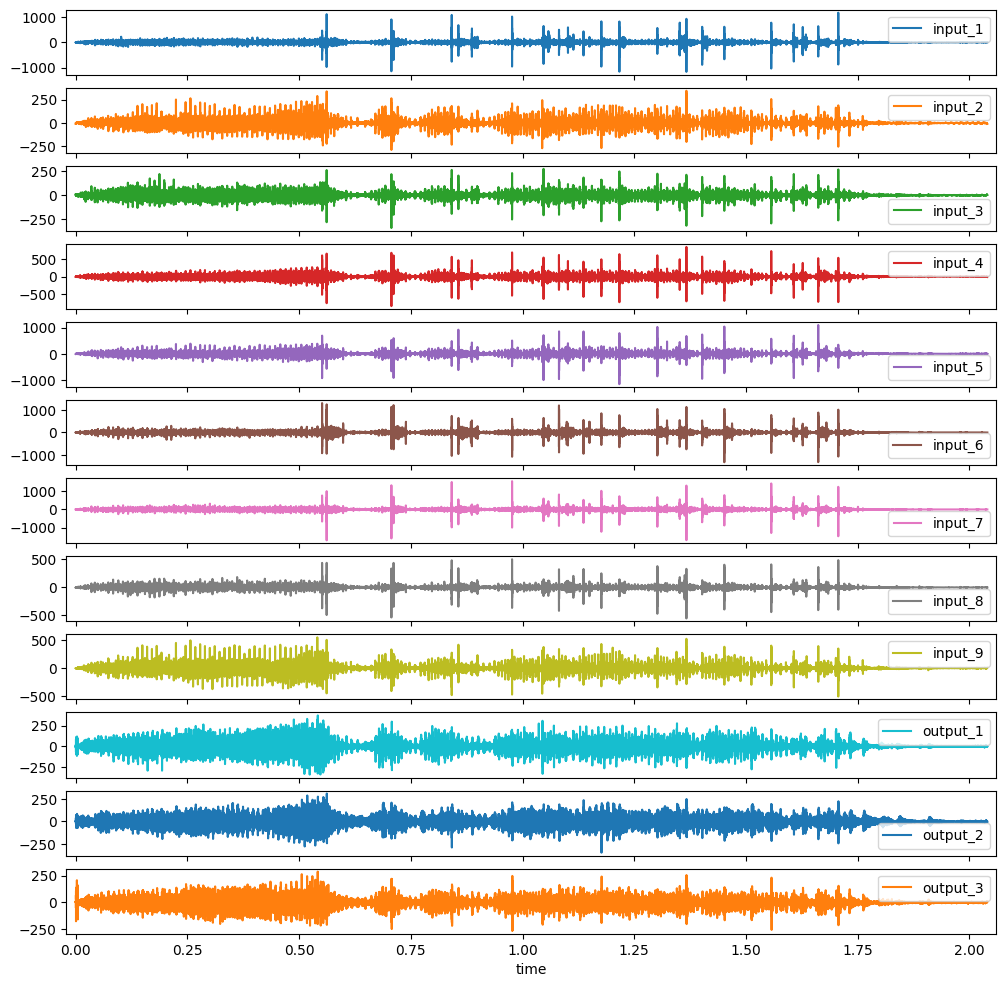

In [13]:
df_list[0].plot(subplots=True, sharex=True, figsize=(12,12))

## Data Preprocessing

When looking at the data, the high range in which the accelerations move is striking. For many machine learning models, preprocessing is therefore necessary. Our toolbox uses the class `Meas_handling` for the entire preprocessing. `Meas_handling` is used to transform the data into a normally distributed range. Furthermore, the entire frequency range is not relevant for our analysis. Therefore, we sample the data from 50000 Hz to 10000 Hz and then filter between 90 and 4000 Hz.

Furthermore, we split the data in training and evaluation data. We use the first two Measurments as training and the last one as evaluation

In [ ]:
fs = 1/np.mean(df_list[0].index.diff().dropna())

data_handle = Meas_handling(df_list[:2], file_names[:2], input_sensors, output_sensors, fs,
                            df_list[2:], file_names[2:])

data_handle.Resample(fs=10000)
freq_lim = (90, 4000)
data_handle.Filter(freq_lim)
data_handle.Scale(StandardScaler())

## Define Model
We define two different Models in our example. 
First we define an Autoregressive Model with exogenious input (ARX) to approximate the functional dependency between input and output as linear combinations. The model is autoregressive as it feeds back in the past outputs into the equation, leading to:

$y_i(t+1) = \mathbf{a} \cdot \mathbf{x}_i(t, ..., t-o_x) + \mathbf{b} \cdot \mathbf{y}_i(t, ..., t-o_y))$

where $\mathbf{a}$ and $\mathbf{b}$ define the different weights for each input as linear combinations, t the time step and $o_x, o_y$ the number of past time steps to include in the computation.

We define our ARX model with order = [10, 10] leading to the past 10 time steps of input and output to be included in the computation. The `ARX.fit` function takes a list of `pandas.DataFrames` as well as the input aud output sensor names as input. We can access the `pandas.DataFrames` in our `data_handle` by simply using the internal variable `train_df` which returns a list of DataFrames for training. (`test_df` would return a list of DataFrames for testing)

In [15]:
arx = ARX(order=[10, 10])
arx.fit(data_handle.train_df, input_sensors, output_sensors)

$\textbf{Congratulation!!!}$ You now have developed your first virtual sensor for acceleration Measurements

The ARX is a purely time domain model and is used in a multitude of use cases with different signal types. Since our datasets are acceleration measurements, we define a second linear approach in the frequency domain, namely the linear Transfer function.

Setting up the model is quite simple as is takes no input variables. The linear_TF fit function takes a list of `pandas.DataFrames` as well as the input aud output sensor names as input. Furthermore, we need to define a window size and sampling rate for the Fourier transformation conducted in out model. 

In [16]:
tf_class = tf(window_size=1024, hop=512, fs=10000)
tf_class.fit(data_handle.train_df, input_sensors, output_sensors)

$\textbf{Congratulation!!!}$ You now have developted your second virtual sensor for acceleration Measurments

## Model Evaluation
To Evaluate our model on testing data we use the predefined functions `comp_pred`, which computes the prediction for a defined track in the data_handle class. As track we choose our testing track, which can be accessed using the internal variable `test_names`. Furthermore we compute

In [17]:
track = data_handle.test_names[0]
models = [arx, tf_class]
pred_df = comp_pred(models, data_handle, track)

<Axes: >

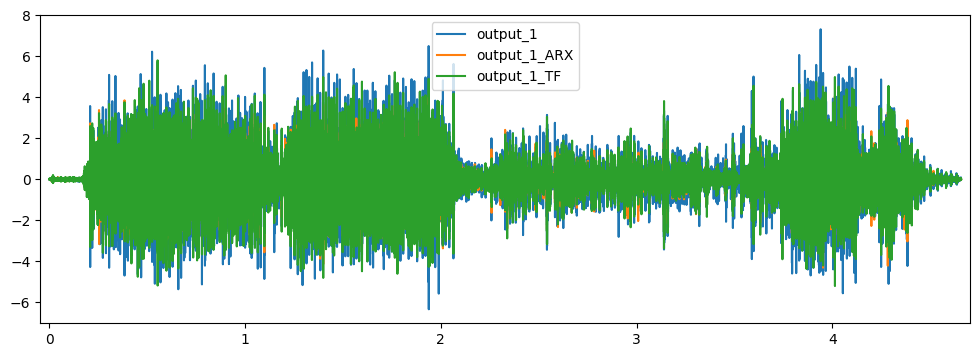

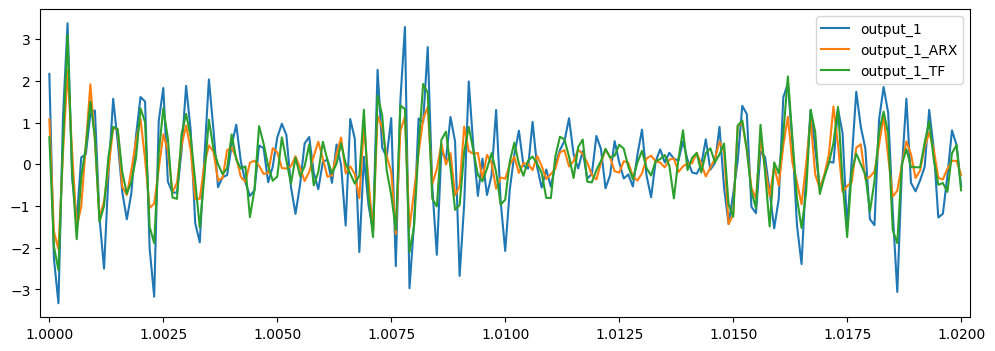

In [18]:
pred_df.filter(regex='output_1').plot(figsize=(12,4))
pred_df.filter(regex='output_1')[1:1.02].plot(figsize=(12,4))

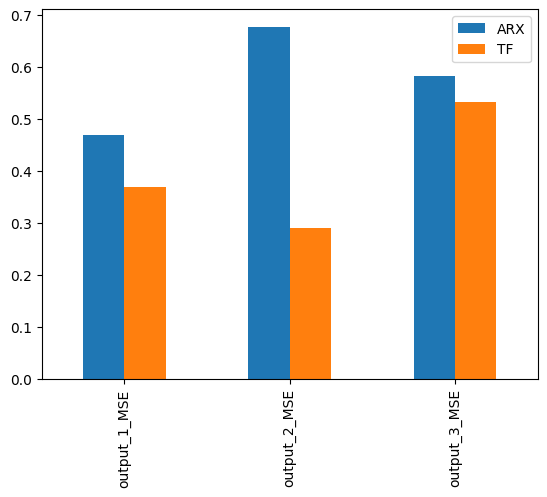

In [19]:
error = comp_error(pred_df, output_sensors, fs, names=['ARX', 'TF'], metrics=['MSE'], freq_range=freq_lim)
for n in ['MSE']:
    error.filter(regex=n, axis=0).plot.bar()